In [41]:
!pip install wurlitzer
!pip install Ninja

In [59]:
%load_ext wurlitzer
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


# Utils

In [66]:
import torch
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

import os,math,sys,torch,re,numpy as np
from types import SimpleNamespace as ns
from collections import namedtuple
# from utils import show_img,load_cuda,cuda_begin,cdiv
def show_img(x, figsize=(4,3), **kwargs):
    "Display HW or CHW format image `x`"
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)
#define CUDA_ERR(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
__host__ __device__ inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a+b-1)/b;}
'''

def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False, name=None):
    "Simple wrapper for torch.utils.cpp_extension.load_inline"
    if name is None: name = funcs[0]
    # flags = "-O3 -Xptxas -O3 -Xcompiler -O3" if opt else "-O0 -Xptxas -O0 -Xcompiler -O0"
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                        verbose=verbose, name=name)

def cdiv(a,b):
    "Int ceiling division of `a` over `b`"
    return (a+b-1)//b

def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)


# Grayscale (ie. vector addition)

In [61]:
img = io.read_image('sample.jpeg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1689, 3000])


tensor([[[120, 121, 122, 123],
         [120, 121, 122, 123],
         [120, 121, 122, 123]],

        [[101, 102, 103, 104],
         [101, 102, 103, 104],
         [101, 102, 103, 104]]], dtype=torch.uint8)

In [62]:
img = tvf.resize(img, 150, antialias=True)
ch,h,w = img.shape
ch,h,w,h*w

(3, 150, 266, 39900)

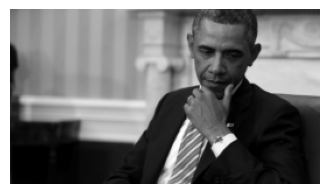

In [63]:
# Basic grayscale proof of concept
def grey_it(x):
  c,h,w = x.shape
  n = h * w
  x = x.flatten()
  output = torch.empty(n,dtype=x.dtype, device=x.device)
  for i in range(n):
    output[i] = 3/10* x[i] + 6/10 * x[i + n] + 1/10 * x[i + 2*n]
  return output.view(h,w)
greyed = grey_it(img)
show_img(greyed, cmap='gray')


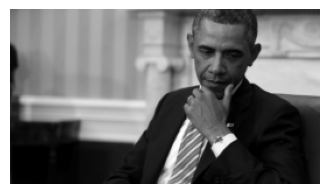

In [64]:
# Grayscale but organised like CUDA
def run_kernel(f, blocks, threads, *args):
    # Schedule by thread by block
    for i in range(blocks):
        for j in range(threads):
            f(i, j, threads, *args)

# blockidx, threadidx, and blockdim as stand-ins for CUDA built-in vars
def grey_kernel(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 3/10*x[i] + 6/10*x[i+n] + 1/10*x[i+2*n]

# cuda structure
def grey_cuda_ish(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    run_kernel(grey_kernel, blocks, threads, x, res, n)
    return res.view(h,w)

grey_img = grey_cuda_ish(img)
show_img(grey_img, cmap='gray')

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module gray have changed. Bumping to version 1 and re-building as gray_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/gray/build.ninja...
Building extension module gray_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=gray_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/gray/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=gray_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/inc

Loading extension module gray_v1...


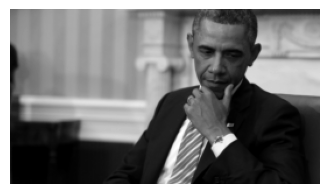

In [70]:
# Actually CUDA
cuda_src = cuda_begin + r'''
__global__ void gray_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor gray(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    gray_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''
cpp_src = "torch::Tensor gray(torch::Tensor input);"
module = load_cuda(cuda_src, cpp_src, ['gray'], verbose=True)
grey_img = module.gray(img.to("cuda"))
show_img(grey_img, cmap='gray')

Comparing speeds

In [71]:
%%time
grey_img = grey_it(img)

CPU times: user 1.51 s, sys: 3.8 ms, total: 1.51 s
Wall time: 1.52 s


In [72]:
%%time
grey_img = grey_cuda_ish(img)

CPU times: user 1.6 s, sys: 11.2 ms, total: 1.62 s
Wall time: 1.89 s


In [74]:
%%time
grey_img = module.gray(img.to("cuda"))

CPU times: user 367 µs, sys: 0 ns, total: 367 µs
Wall time: 376 µs


# Matrix Multiplicatiion

In [75]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"
module = load_cuda(cuda_src, cpp_src, ['matmul'])

In [78]:
m1 = torch.randn(100, 200)
m2 = torch.randn(200, 100)
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [81]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [82]:
%%time
tr = matmul(m1, m2)

CPU times: user 6.11 ms, sys: 12 µs, total: 6.12 ms
Wall time: 5.86 ms


In [84]:
%%time
res=module.matmul(m1c, m2c).cpu()

CPU times: user 393 µs, sys: 0 ns, total: 393 µs
Wall time: 413 µs


In [85]:
torch.isclose(tr, res, atol=1e-5).all()

tensor(True)